# Image Style Transfer

You will need the following package to run this notebook:

`keras_contrib` - install with:

`pip install git+https://www.github.com/keras-team/keras-contrib.git`

## Introduction
A recent development in applications of deep nerual networks is the concept of style transfer. This is form of image modification by which a network takes a content image and applies the style of another image to it. The original implementation of neural style transfer was done by Leon Gatys et al. in 2015.

The main idea behind style transfer is to maintain the structure of the content image while applying the texture of the style image. Here, the content of an image refers to the larger structures in the image, say the dog or fencing in the following picture:
<img src="./images/newton.jpg">

When we refer to style, we are refering to the colors, lines, and shapes that occur across an entire image. An example is the waves in the following picture:
<img src="./images/wave_style.png" height="256" width="350">

The result of applying the waves style to the picture of the dog is show here:
<img src="./images/newton_wave.jpg">

## History

### Image Filters
It is common for computer vision algorithms to use statistical filters to determine the features of an image. The DAISY and Gabor filters are both common.

Gabor filters can have and scale and orientation. When a Gabor filter is passed over an image that has the same texture as the filter (same feature and orientation) it produces a response. It is believed that this is the same way the himan visual cortex processes images for features. In 1987, David Field showed that the orientation and spatial-frequency tuning of cortical cells worked similarly to Gabor filters for representing the content of natural landscape images. (David Field, Relations between the statistics of natural images and the response properties of cortical cells)

### ImageNet
In 2012, Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton showed that deep nural networks could dramatically out perform what was previously considered state-of-the-art. Their convolutional neural network was able to perform image classification on images with an error rate of 15.3%, while the second best entry had an error rate of 26.2%. (Krizhevsky et al., ImageNet Classification with Deep Convolutional Neural Networks)

They showed that deep convolutional neural networks would be the predominate method for image classification moving forward.

### A Neural Algorithm of Artistic Style
Up to this point, no one had used neural networks to generate artistic images. In 2015, Leon Gatys, Alexander Ecker, and Matthias Bethge figured that since neural networks had been so useful for image classification, that these networks could be used to create high quality artistic images. (Leon Gatys et al., A Neural Algorithm of Artistic Style)

When CNNs are trained on images, the images are fed forward through the convolutional layers such that the layers form a hierarchy. Each layer can be viewed as a collection of filters that respond most when certain features are present in the image. In other words, these filters are capturing the content of an image. Where the lower layers activate when a specific object is detected in the image, the uppermost layers represent the spatial arrangement of those objects in the image.

Similarly, the team used the filter responses in each convolutional layer to capture the texture of a style image. Because the lower layers capture features local to a particular area of the image, and the higher layers capture global details, all of the layers are used to detemine the style so that the style can be represented and applied at any spatial scale. The correlations between the responses of each layer are compared to build the style representation.

#### Gram Matrix
Gatys et al. used VGG19 to train their style network. The feature responses for each layer from the style image are given by the Gram Matrix. Then, the loss function that is minimized is the mean-squared distance between the entries in the Gram Matrix.

### Perceptual Losses for Real-Time Style Transfer and Super-Resolution
In 2016, Justin Johnson, Alexandre Alahi, and Li Fei-Fei published a paper showing that the problem put forward by Gatys et al. could be solved with similar quality, but three orders of magnitude faster, nearing real-time style transfer on images. (Johnson et al., Perceptual Losses for Real-Time Style Transfer and Super-Resolution)

This team combined the benefits of using per-pixel loss functions, where the output image is directly compared to a ground truth image, and perceptual loss functions, which represent high level features. They trained a image transformation network by using VGG16 as a loss network to define several loss functions.

The output image from the transformation network, the source content image, and the source style image are all fed through the loss network. The loss is higher when the output image differs from the content image so that the content stays recongnizable. The style is again calculated using the Gram matrix. However, since both the style image and the output image are being fed through the loss network, the loss function is takes ans the Frobenius norm of the difference between the two matricies.

This method offers such a dramatic speedup because the images only need to be run through the network in a feed-forwad manner, whereas Gatys et al. were using a forward and backward pass through the loss network.

## Video Style Transfer
If you want to perform style transfer on videos, it is important to include a temporal consistency measure so that the style is applied consistently to the same object as its position changes in frames. If you simply apply the style transfer model to each individual frame in the video, they subtle changes between frames will result in the style varying slightly between frames. When the frames are reassebled, the style will look like it is jittering.

Manuel Ruder, Alexey Dosovitskiy, and Thomas Brox created a model that incorporates short-term consistency, long-term consistency, and temporal consistency to produce videos in which the style appears as if it is applied directly to the landscape, rather than each individual frame. (Manuel Ruder et al., Artistic style transfer for videos)

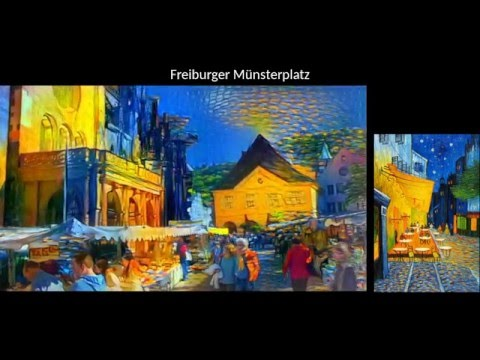

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Khuj4ASldmU')

## Implementations

**Original, Gatys et al.**: An excellent implementation of the Gatys approach for style transfer is available from Francois Chollet (as part of the book for this course):
- https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.3-neural-style-transfer.ipynb

**Fast, Johnson et al.**: An approach for fast style transfer has been implemented for this class by several contributors (Justin Ledford and Luke Wood) and is available here:  
- https://github.com/8000net/StyleTransfer

**Universal, Li et al.**: Finally, an implementation of Universal style transfer is available for this course from Justin Ledford:
- https://github.com/8000net/universal-style-transfer-keras

Please look at each implementation. Read below for an intuition about the strengths and weaknesses of each approach. 

## Review
A fantastic review of current style transfer techniques was made available by Yongcheng Jing, et al. This paper goes into details about a variety of other applications for neural style transfer, including audio style transfer for changing the genere of music, fashion style transfer for changing the style of clothes someone is waering in an image, and doodle style transfer which takes rough sketches and produces refined, color images. A high-level overview of the different style transfer domains is given in the following figure:

<img src="./images/st-taxonomy.png">

In this paper, all of the style transfer methods descirbed here, and more, are compared and benchmarked on an NVIDIA Quadro M6000. The runtimes of the various method for differing input image sizes are given in the following table:

<img src="./images/st-benchmarks.png">

(Neural Style Transfer: A Review, Yongcheng Jing *et al.*)

### Future
Several companies are investing heavily in style transfer research. In particular NVIDIA is sponsoring numerous papers in the realm of neural style transfer. It is possible that they are looking to include style transformation networks that are highly optimized for their graphics cards. This could be useful for video game developers. Perhaps there will be a time when the game developers only need to develop their graphics for a perticular season, and then the graphics card is responsible for transfering the scene to another season or time of day.

## The Loss Function
Similar to any other neural network, we define a loss function and work to minimize that loss. We will base our loss function off of the Fast Feed-Forward implementation by Justin Johnson et al. If we have functions `style` and `content` that can mathematicaly represent the style and content of an image respectfully, we can define our loss function as follows:

`loss = distance(style(style image) - style(generated image)) + 
       distance(content(content image) - content(generated image))`

(Chollet, https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.3-neural-style-transfer.ipynb)

While defining a function that mathematically represents the content or style of an image does not seem trivial, what Gatys et al. were able to show was that deep neural networks could be used to represent the content and style of images mathematically.

### Content Loss
As discussed in the CNN Visualization lecture, the activations of lower levels of a CNN react to small details and features, while the upper layers tend to represent higher level structures within the image. Therefore, the upper levels of an image are more suitable for representing image content.

If we wish to determine the content loss, we can then compare the activations of the upper layers of our network when we feed it the content and generated image. A good option for this is the L2 norm, which was used by Gatys et al. in their original implementation.

$$ \ell^{\phi, j}_{feat}(\widehat{y}, y_c) = \frac{1}{C_jH_jW_J} \lVert \phi_j(\widehat{y}) - \phi_j(y_c) \rVert^2_2 $$

### Style Loss
Stlye loss is more complicated. If we want to represent the style of an image, it would not serve us well to only consider they style at one scale. Instead, we want to consider the image at multiple scales so that large and small features of the content image all recieve style transformation. To do this, Gatys et al. used the Gram matrix of a layer's activations. The Gram matrix captures the correlations between features of a given layer, which in turn capture pattern statistics at a given scale.

To do that, we can extract the features at the various ReLU layers of VGG16.
<img src="./images/transform_net.png">
(Johnson et al., Perceptual Losses for Real-Time Style Transfer and Super-Resolution)

The style loss is then defined as the squared Frobenius norm of the difference between the Gram matrices of the output and target images:

$$ \ell^{\phi, j}_{style}(\widehat{y}, y_s) = \lVert G^{\phi}_j(\widehat{y}) - G^{\phi}_j(y_s) \rVert^2_F $$

The Gram matrix can be computed efficiently by:

$$ G^{\phi}_j(x) = \psi\psi^T / C_jH_jW_j $$

where $\psi$ is $\phi_j(x)$ reshaped with shape $ C_j \times H_jW_j $.

With multiple style layers, we take the sum of losses for each layer.

### Total Variation Regularization

TV loss is a signal processing concept that is used to measure noise in an image.

The actual TV loss formula is not easily differentiable.
Therefore, in machine learning and minimization problems the following formula is used as minimizing this formula also greatly reduces TV loss.

$$ \ell_{TV}(\widehat{y}) = \sum_{ij}\lVert\widehat{y}_{i,j+1}-\widehat{y}_{i,j}\lVert + \lVert\widehat{y}_{i+1,j}-\widehat{y}_{i,j}\lVert $$

The most important thing to understand about TV loss in this problem is that it represents an estimation of noise in an image, assuming the noise is major deviations in a local neighborhood. Therefore, practiacally the loss works to help incentivize the network not to make too many sudden pixel changes. 

To read more on TV loss look at some of the citations referenced here:
https://en.wikipedia.org/wiki/Total_variation_denoising#2D_signal_images



## Style Transfer Example
Here we will use VGG to transfer the style of the wave image above onto the image of the dog. We will use a pre-trained version of the Fast STyle Transfer algorithms. It has been trained using the "wave" image.

In [1]:
from keras.layers import Conv2D, Conv2DTranspose, Input, Lambda, Activation
from keras.models import Model
import keras.layers
from keras.initializers import TruncatedNormal

from keras_contrib.layers.normalization import InstanceNormalization

WEIGHTS_INIT_STDEV = .1

def Conv2DInstanceNorm(inputs, filters, kernel_size,
                           strides=1, relu=True):
    weights_init = TruncatedNormal(stddev=WEIGHTS_INIT_STDEV, seed=1)
    conv = Conv2D(filters,
                  (kernel_size, kernel_size),
                  strides=strides,
                  padding='same',
                  kernel_initializer=weights_init,
                  use_bias=False)(inputs)
    norm = InstanceNormalization(axis=3)(conv)
    if relu:
        norm = Activation('relu')(norm)
    return norm

def Conv2DTransposeInstanceNorm(inputs, filters, kernel_size,
                                strides=1, relu=True):
    weights_init = TruncatedNormal(stddev=WEIGHTS_INIT_STDEV, seed=1)
    conv = Conv2DTranspose(filters,
                           (kernel_size, kernel_size),
                           strides=strides,
                           padding='same',
                           kernel_initializer=weights_init,
                           use_bias=False)(inputs)
    norm = InstanceNormalization(axis=3)(conv)
    if relu:
        norm = Activation('relu')(norm)
    return norm

def Conv2DResidualBlock(inputs):
    tmp     = Conv2DInstanceNorm(inputs, 128, 3)
    tmp2    = Conv2DInstanceNorm(tmp, 128, 3, relu=False)
    return keras.layers.add([inputs, tmp2])

def TransformNet(inputs):
    conv1   = Conv2DInstanceNorm(inputs, 32, 9)
    conv2   = Conv2DInstanceNorm(conv1, 64, 3, strides=2)
    conv3   = Conv2DInstanceNorm(conv2, 128, 3, strides=2)
    resid1  = Conv2DResidualBlock(conv3)
    resid2  = Conv2DResidualBlock(resid1)
    resid3  = Conv2DResidualBlock(resid2)
    resid4  = Conv2DResidualBlock(resid3)
    resid5  = Conv2DResidualBlock(resid4)
    conv_t1 = Conv2DTransposeInstanceNorm(resid5, 64, 3, strides=2)
    conv_t2 = Conv2DTransposeInstanceNorm(conv_t1, 32, 3, strides=2)
    conv_t3 = Conv2DInstanceNorm(conv_t2, 3, 9, relu=False)
    tanh = Activation('tanh')(conv_t3)
    preds = Lambda(lambda x : x * 150 + 255./2)(tanh)
    return preds

Using TensorFlow backend.


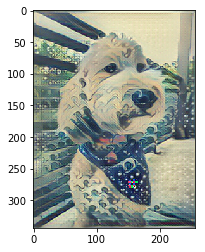

In [5]:
from keras.layers import Input
from keras.models import Model
from keras.preprocessing import image
import numpy as np
from scipy.misc import imsave
import matplotlib.pyplot as plt

# Get input image
input_img = image.load_img('./images/newton.jpg')
input_img = image.img_to_array(input_img)
input_img = np.expand_dims(input_img, axis=0)


# Load model
_, h, w, c = input_img.shape
inputs = Input(shape=(h, w, c))
transform_net = TransformNet(inputs)
model = Model(inputs, transform_net)
model.load_weights('./models/wave.h5')

output_img = model.predict([input_img])[0]
plt.imshow(output_img/255)
plt.show()

## Universal Style Transfer
The models above are trained to work for a single style. Using these methods, in order to create a new style transfer model, you have to train the model with a wide variety of content images.

Recent work by Yijun Li et al. shows that it is possible to create a model that generalizes to unseen style images, while maintaining the quality of output images.

Their method works by treating style transfer as an image reconstruction task. They use the output of a VGG19 ReLU layer to encode features of various content images and traing a decoder to reconstruct these images. Then, with these two networks fixed, they feed the content and the style image into the encoder and use a whitening and coloring transform so that the covarience matrix of the features matches the covarience matrix of the style.

This process can then be expanded to the remaining ReLU layers of VGG19 to create a style transfer pipeline that can apply to all spatial scales.

Since only content images were used to train the encoder and decoder, additional training is not needed when generalizing this to new styles.

<img src="images/universal-style-transfer.png" style="width: 600px;"/>
(Yijun Li et al., Universal Style Transfer)

<img src="images/doge_the_scream.jpg" style="width: 300px;"/>
<img src="images/doge_mosaic.jpg" style="width: 300px;"/>

The results are pretty impressive, but there are some patches of blurriness, most likely as a result of the transforms.

### Whitening Transform

The whitening transform removes the style from the content image, keeping the global content structure.

The features of the content image, $f_c$, are transformed to obtain $\hat{f}_c$, such that the feature maps
are uncorrelated ($\hat{f}_c \hat{f}_c^T = I$),

$$
    \hat{f}_c = E_c D_c^{- \frac{1}{2}} E_c^T f_c
$$

where $D_c$ is a diagonal matrix with the eigenvalues of the covariance matrix $f_c f_c^T \in R^{C \times C}$,
and $E_c$ is the corresponding orthogonal matrix of eigenvectors, satisfying $f_c f_c^T = E_c D_c E_c^T$.

<img src="images/whitening.png" style="width: 300px;"/>
(Yijun Li et al., Universal Style Transfer)


### Coloring Transform

The coloring transform adds the style from the style image onto the content image.

The whitening transformed features of the content image, $\hat{f}_c$, are transformed to obtain $\hat{f}_{cs}$, such that the feature maps have that desired correlations ($\hat{f}_{cs} \hat{f}_{cs}^T = f_s f_s^T$),

$$
    \hat{f}_{cs} = E_s D_s^{\frac{1}{2}} E_s^T \hat{f}_c
$$

where $D_s$ is a diagonal matrix with the eigenvalues of the covariance matrix $f_s f_s^T \in R^{C \times C}$,
and $E_s$ is the corresponding orthogonal matrix of eigenvectors, satisfying $f_c f_c^T = E_c D_c E_c^T$.

Before each transform step, the mean of the corresponding feature maps are subtracted, and the mean of the style features are added back to the final transformed features.

## References

Relations between the statistics of natural images and the response properties of cortical cells, David Field: https://www.osapublishing.org/DirectPDFAccess/E1403855-9CE3-257F-B8A7F9163F741660_2980/josaa-4-12-2379.pdf?da=1&id=2980&seq=0&mobile=no

Neural Style Transfer reference notebook, Francois Chollet: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.3-neural-style-transfer.ipynb

A Neural Algorithm of Artistic Style, Leon Gatys et al.: https://arxiv.org/pdf/1508.06576.pdf

ImageNet Classification with Deep Convolutional Neural Networks, Alex Krizhevsky et al.:
https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf

Perceptual Losses for Real-Rime Style Transfer and Super-Resolution, Justin Johnson et al.:
https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf

Artistic style transfer for videos, Manuel Ruder et al.: https://arxiv.org/pdf/1604.08610.pdf

Neural Style Transfer: A Review, Yongcheng Jing et al.: https://arxiv.org/abs/1705.04058

Universal Style Transfer, Yijun Li et al.: https://arxiv.org/pdf/1705.08086.pdf